# MAD Portfolio Optimization

NOTE: THIS IS IN EARLY DEVELOPMENT.  STILL NEED TO FINALIZE MODEL, TEST, AND REVISE NARRATIVE.  PRIORITY IS TO FINISH BY 3/18.

In [304]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats

import pyomo.environ as pyo

## Investment objectives

* Maximize returns
* Reduce Risk through diversification

What we observe is that even a small amount of diversification can dramatically reduce the downside risk of experiencing a loss. We also see the upside potential has been reduced. What hasn't changed is the that average profit remains at \$50,000. Whether or not the loss of upside potential in order to reduce downside risk is an acceptable tradeoff depends on your individual attitude towards risk. 

### Value at risk (VaR)

[Value at risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk) is a measure of investment risk. Given a histogram of possible outcomes for the profit of a portfolio, VaR corresponds to negative value of the 5th percentile. That is, 5% of all outcomes would have a lower outcome, and 95% would have a larger outcome. 

The [conditional value at risk](https://en.wikipedia.org/wiki/Expected_shortfall) (also called the expected shortfall (ES), average value at risk (aVaR), and the expected tail loss (ETL)) is the negative of the average value of the lowest 5% of outcomes. 

The following cell provides an interactive demonstration. Use the slider to determine how to break up the total available capital into a number of smaller investments in order to reduce the value at risk to an acceptable (to you) level.  If you can accept only a 5% probability of a loss in your portfolio, how many individual investments would be needed?

Average Profit = $49825
Value at Risk (95%) = $1004
Conditional Value at Risk (95%) = $13011


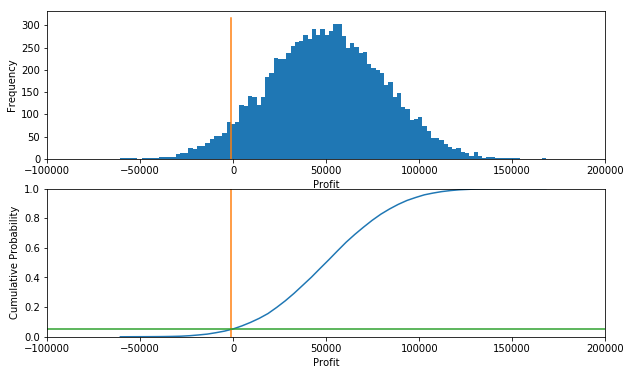

In [5]:
#@title Value at Risk (VaR) Demo { run: "auto", vertical-output: true }
Ninvestments = 8 #@param {type:"slider", min:1, max:20, step:1}

from statsmodels.distributions import ECDF

W0 = 100000.00
Ntrials = 10000

def sim(Ninvestments = 5):

    Profit = list()
    for n in range(0, Ntrials):
        W1 = sum([(W0/Ninvestments)*random.uniform(0,3.00) for _ in range(0,Ninvestments)])
        Profit.append(W1-W0)
        
    print('Average Profit = ${:.0f}'.format(np.mean(Profit)).replace('$-','-$'))

    VaR = -sorted(Profit)[int(0.05*Ntrials)]
    print('Value at Risk (95%) = ${:.0f}'.format(VaR).replace('$-','-$'))
    
    cVaR = -sum(sorted(Profit)[0:int(0.05*Ntrials)])/(0.05*Ntrials)
    print('Conditional Value at Risk (95%) = ${:.0f}'.format(cVaR).replace('$-','-$'))

    plt.figure(figsize=(10,6))
    plt.subplot(2, 1, 1)
    plt.hist(Profit, bins=100)
    plt.xlim(-100000, 200000)
    plt.plot([-VaR, -VaR], plt.ylim())
    plt.xlabel('Profit')
    plt.ylabel('Frequency')

    plt.subplot(2, 1, 2)
    ecdf = ECDF(Profit)
    x = np.linspace(min(Profit), max(Profit))
    plt.plot(x, ecdf(x))
    plt.xlim(-100000, 200000)
    plt.ylim(0,1)
    plt.plot([-VaR, -VaR], plt.ylim())
    plt.plot(plt.xlim(), [0.05, 0.05])
    plt.xlabel('Profit')
    plt.ylabel('Cumulative Probability');
    
sim(Ninvestments)

## Import historical asset prices

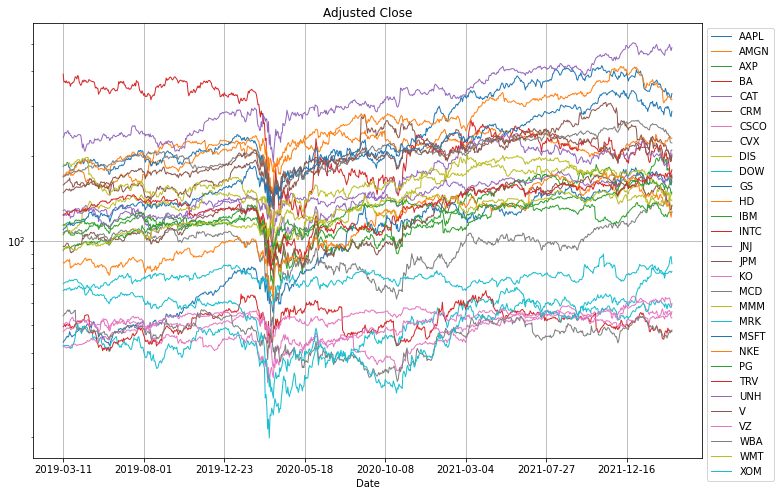

In [393]:
# import historical asset prices

import os
import glob

data_path = os.path.join("data", "stocks")
files = glob.glob(os.path.join(data_path, "*.csv"))

assets = pd.DataFrame()
for filename in sorted(files):
    data = pd.read_csv(filename, index_col=0)
    sym = filename.split("/")[-1].split(".")[0]
    assets[sym] = data["Adj Close"]
    
assets.fillna(method="bfill", inplace=True)
assets.fillna(method="ffill", inplace=True)
    
assets.plot(logy=True, figsize=(12, 8), grid=True, lw=1, title="Adjusted Close")
plt.legend(bbox_to_anchor=(1.0, 1.0))

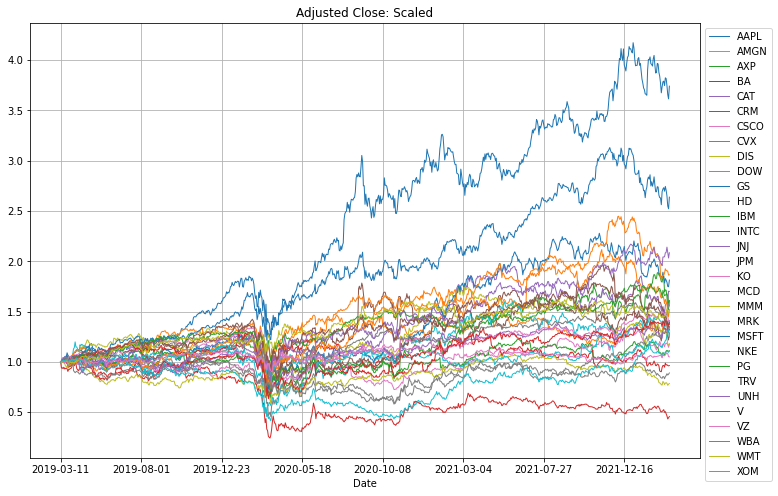

In [394]:
# scaled asset prices

assets_scaled = assets.div(assets.iloc[0])
assets_scaled.plot(figsize=(12, 8), grid=True, lw=1, title="Adjusted Close: Scaled")
plt.legend(bbox_to_anchor=(1.0, 1.0))

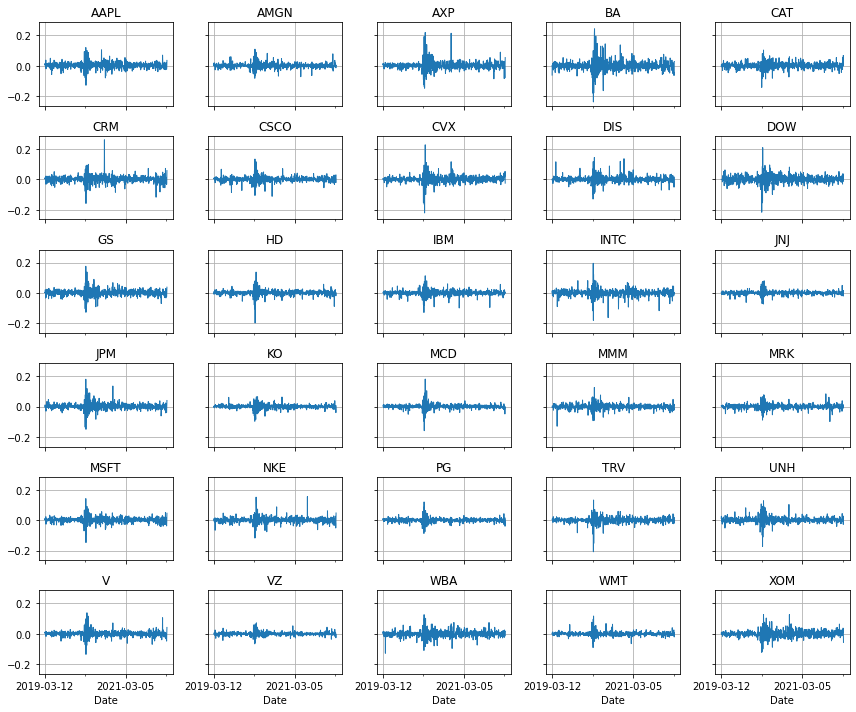

In [395]:
# daily returns

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)
    
plt.tight_layout()

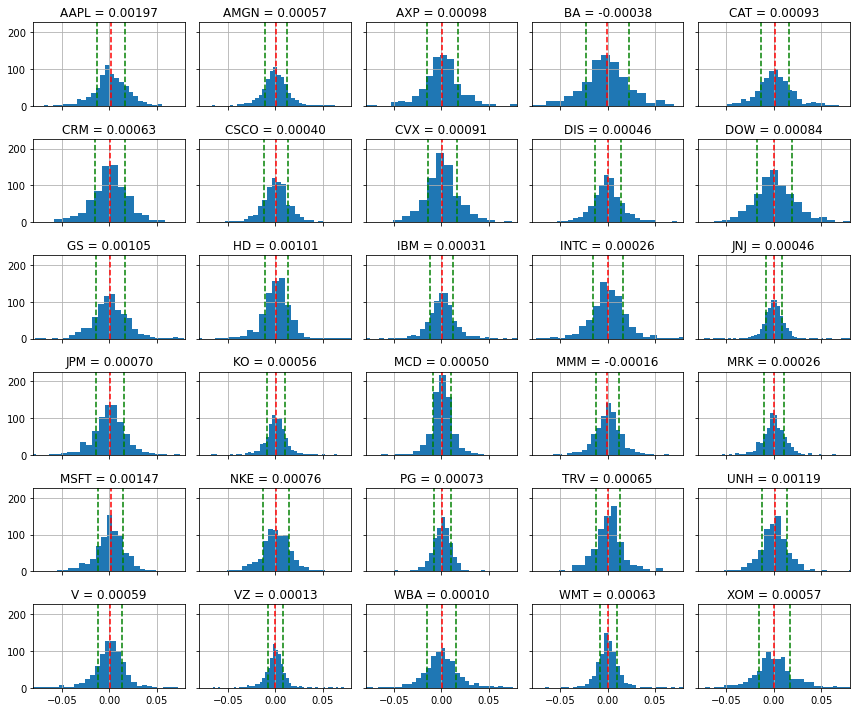

In [398]:
# distributions of returns

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    mean_return = daily_returns[s].mean()
    mean_absolute_deviation = abs((daily_returns[s] - mean_return)).mean()
    a.set_title(f"{s} = {mean_return:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return, color='r', linestyle="--")
    a.axvline(mean_return + mean_absolute_deviation, color='g', linestyle='--')
    a.axvline(mean_return - mean_absolute_deviation, color='g', linestyle='--')
    
plt.tight_layout()

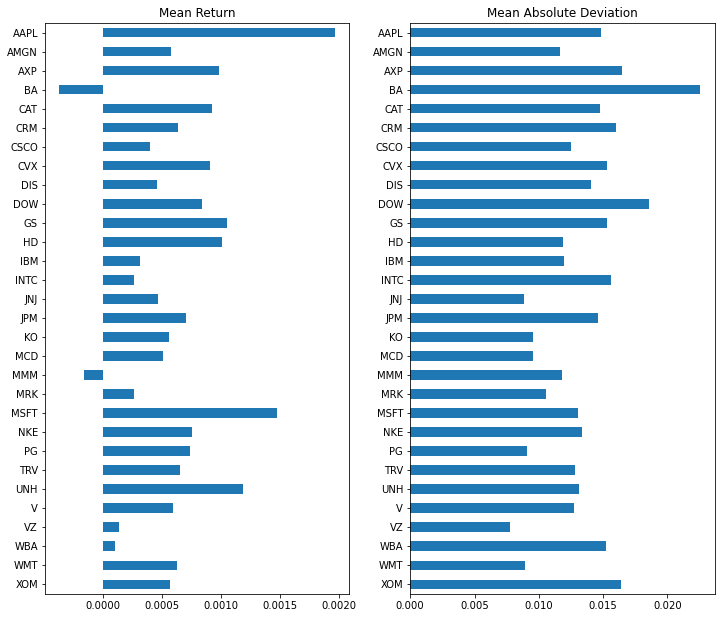

In [400]:
# bar charts of mean return and mean absolute deviation in returns

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 2, figsize = (12, 0.35*len(daily_returns.columns)))
mean_return.plot(kind='barh', ax=ax[0], title="Mean Return")
ax[0].invert_yaxis()
mean_absolute_deviation.plot(kind='barh', ax=ax[1], title='Mean Absolute Deviation');
ax[1].invert_yaxis()

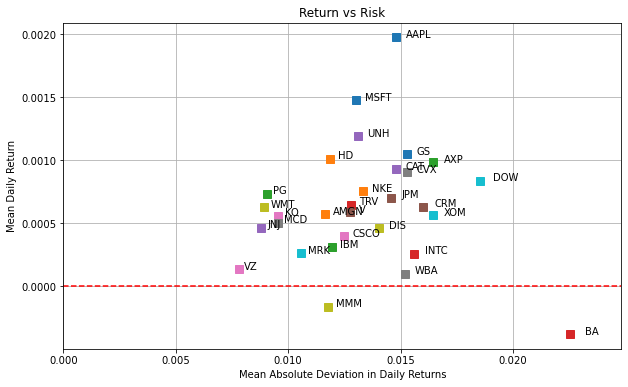

In [405]:
# plot return vs risk

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)

ax.set_xlim(0, 1.1*max(mad))
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs Risk')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

## Porfolio

The return on a portfolio with weights $w_a$ for asset $a$ is 


$$
\begin{align*}
MAD  = \min \frac{1}{T} \sum_{t\in TIME} \left| \sum_{a\in ASSETS} w_a (r_{t, a} - \bar{r}_a) \right|
\end{align*}
$$

where $r_{t, a}$ is the return on asset $a$ at time $t$, $\bar{r}_a$ is the mean return for asset $a$, and $w_a$ is the fraction of the total portfolio that is invested in asset $a$.

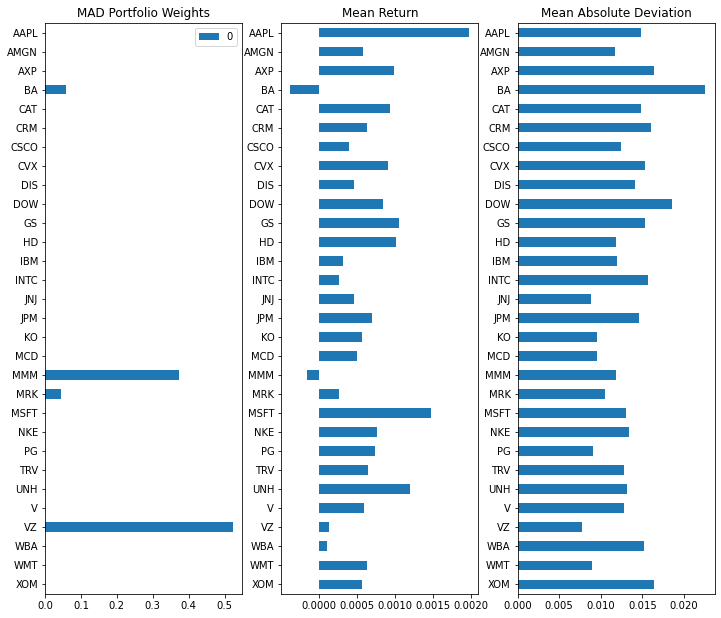

In [476]:
import pyomo.environ as pyo

def mad_portfolio(assets):
    
    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel()
    
    m.Rp = pyo.Param(mutable=True, default=0)
    m.W_lb = pyo.Param(mutable=True, default=0)
    
    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))
    
    m.w = pyo.Var(m.ASSETS, bounds=(m.W_lb, 10))
    m.r_pos = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.r_neg = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    
    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t-1]
        return m.r_pos[t] - m.r_neg[t] == sum(m.w[a]*(daily_returns.loc[date, a] - mean_return[a]) for a in m.ASSETS)
    
    @m.Objective(sense=pyo.minimize)
    def mad(m):
        return sum(m.r_pos[t] + m.r_neg[t] for t in m.TIME)/len(m.TIME)
    
    @m.Constraint()
    def sum_of_weights(m):
        return 1 == sum(m.w[a] for a in m.ASSETS)
    
    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[a] * mean_return[a] for a in m.ASSETS) == m.Rp
    
    return m
    
m = mad_portfolio(assets)
pyo.SolverFactory('cbc').solve(m)

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()
mad_portfolio_weights = pd.DataFrame([m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS))

fig, ax = plt.subplots(1, 3, figsize = (12, 0.35*len(daily_returns.columns)))
mad_portfolio_weights.plot(kind='barh', ax=ax[0], title="MAD Portfolio Weights")
ax[0].invert_yaxis()
mean_return.plot(kind='barh', ax=ax[1], title="Mean Return")
ax[1].invert_yaxis()
mean_absolute_deviation.plot(kind='barh', ax=ax[2], title='Mean Absolute Deviation');
ax[2].invert_yaxis()

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: <undefined>


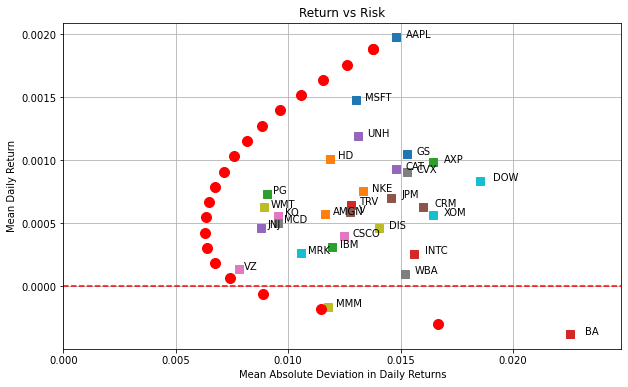

In [481]:
# plot return vs risk

daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)
    
ax.set_xlim(0, 1.1*max(mad))
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs Risk')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

import numpy as np

m.W_lb = 0
for Rp in np.linspace(-0.0003, 0.0020, 20):
    m.Rp = Rp
    pyo.SolverFactory('cbc').solve(m)
    mad_portfolio_weights = pd.DataFrame([m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS))

    portfolio_returns = daily_returns.dot(mad_portfolio_weights)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_mean_absolute_deviation = abs(portfolio_returns - portfolio_mean_return).mean()
    ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, 'ro', ms=10)


## Statistics of daily asset returns

In [478]:
S_hist = pd.read_csv('data/Historical_Adjusted_Close.csv', index_col=0)

S_hist.dropna(axis=1, how='any', inplace=True)
S_hist.index = pd.DatetimeIndex(S_hist.index)

portfolio = list(S_hist.columns)
print(portfolio)
S_hist.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'data/Historical_Adjusted_Close.csv'

## Select a recent subperiod of the historical data

In [43]:
nYears = 1.5
start = S_hist.index[-int(nYears*252)]
end = S_hist.index[-1]

print('Start Date:', start)
print('  End Date:', end)

S = S_hist.loc[start:end]
S.head()

Start Date: 2017-11-28 00:00:00
  End Date: 2019-05-31 00:00:00


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,HD,IBM,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2017-11-28,169.1244,93.2036,259.9291,134.2662,36.0972,109.9599,100.9739,17.0878,170.5630,142.4311,...,58.4100,34.0208,85.0389,32.3601,128.5122,211.7681,113.8682,45.6521,93.0304,76.6965
2017-11-29,165.6162,94.4949,261.1997,133.3678,35.8580,110.6492,102.7608,17.1528,172.0796,143.4400,...,59.1746,34.3624,85.0199,33.3286,129.9808,218.3718,114.3035,46.6620,93.7899,77.2599
2017-11-30,167.9322,95.5807,268.4741,136.3528,35.6858,112.3583,102.3507,16.9765,174.5747,143.8323,...,59.2335,34.4099,85.6001,33.2372,130.9857,224.2896,117.4862,47.5878,93.4726,78.2178
2017-12-01,167.1504,95.7274,263.2171,136.7102,35.9728,112.8493,102.7706,16.5959,175.1572,144.5703,...,58.9001,34.4953,85.9521,33.3468,131.6040,222.9232,116.1996,47.9244,93.5880,78.3775
2017-12-04,165.9289,96.4415,269.6089,136.6909,36.0876,114.1052,107.6235,16.6609,179.5065,146.1584,...,59.1165,34.2201,86.9509,34.0503,131.7489,217.6544,116.1222,48.3639,93.2611,78.4808


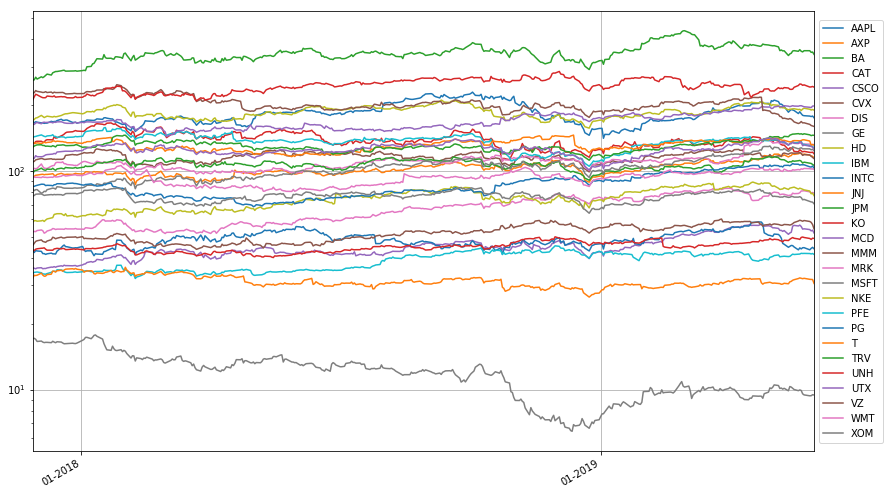

In [44]:
fig, ax = plt.subplots(figsize=(14,9))
S.plot(ax=ax, logy=True)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True)

## Return on a portfolio

Given a portfolio with value $W_t$ at time $t$, return on the portfolio at $t_{t +\delta t}$ is defined as

\begin{align*}
r_{t + \delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}}
\end{align*}

For the period from $[t, t+\delta t)$ we assume there are $n_{j,t}$ shares of asset $j$ with a starting value of $S_{j,t}$ per share. The initial and final values of the portfolio are then 

\begin{align*}
W_t & = \sum_{j=1}^J n_{j,t}S_{j,t} \\
W_{t+\delta t} & = \sum_{j=1}^J n_{j,t}S_{j,t + \delta t}
\end{align*}

The return of the portfolio is given by

\begin{align*}
r_{t+\delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}} \\
& = \frac{\sum_{j=1}^Jn_{j,t}S_{j,t+\delta t} - \sum_{j=1}^J n_{j,t}S_{j,t}}{W_{t}} \\
& = \frac{\sum_{j=1}^J n_{j,t}S_{j,t}r_{j, t+\delta t}}{W_{t}} \\
& = \sum_{j=1}^J \frac{n_{j,t}S_{j,t}}{W_{t}} r_{j, t+\delta t}
\end{align*}

where $r_{j,t+\delta t}$ is the return on asset $j$ at time $t+\delta t$. 

Defining $W_{j,t} = n_{j,t}S_{j,t}$ as the wealth invested in asset $j$ at time $t$, then $w_{j,t} = n_{j,t}S_{j,t}/W_{t}$ is the fraction of total wealth invested in asset $j$ at time $t$. The portfolio return is then given by 

\begin{align*}
r_{t+\delta t} & = \sum_{j=1}^J w_{j,t} r_{j, t+\delta t} 
\end{align*}

on a single interval extending from $t$ to $t + \delta t$.

### Equally weighted portfolio

An equally weighted portfolio allocates an equal amount of capital to each component of the portfolio. The allocation can be done once and held fixed thereafter, or could be reallocated periodically as asset prices change in relation to one another.

#### Constant fixed allocation

If the initial allocation among $J$ assets takes place at $t=0$, then

$$w_{j,0} = \frac{1}{J} = \frac{n_{j,0} S_{j, t=0}}{W_{0}}$$

The number of assets of type $j$ included in the portfolio is given by

$$n_{j,0} = \frac{W_0}{J S_{j,0}} $$

which is then fixed for all later times $t > 0$. The value of the portfolio is given by

\begin{align*}
W_t & = \sum_{j=1}^J n_{j,0}S_{j,t} \\
& = \frac{W_{0}}{J} \sum_{j=1}^J \frac{S_{j,t}}{S_{j,0}}
\end{align*}

Note that this portfolio is guaranteed to be equally weighted only at $t=0$. Changes in the relative prices of assets cause the relative weights of assets in the portfolio to change over time.

#### Continually rebalanced

Maitaining an equally weighted portfolio requires buying and selling of component assests as prices change relative to each other. To maintain an equally portfolio comprised of $J$ assets where the weights are constant in time,

\begin{align*}
w_{j,t} & = \frac{1}{J} = \frac{n_{j,t}S_{j,t}}{W_t} & \forall j, t
\end{align*}

Assuming the rebalancing occurs at fixed points in time $t_k$ separated by time steps $\delta t$, then on each half-closed interval $[t_k, t_k+\delta t)$

\begin{align*}
n_{j,t} & = \frac{W_{t_k}}{J S_{j,t_k}} \\
\end{align*}

The portfolio

\begin{align*}
W_{t_k + \delta t} & = \sum_{j=1}^J n_{j,t_k} S_{j, t_k + \delta t}
\end{align*}

\begin{align*}
W_{t_k + \delta t} & = W_{t_k} \sum_{j=1}^J  \frac{S_{j, t_k + \delta t}}{J S_{j,t_k}}
\end{align*}

Letting $t_{k+1} = t_k + \delta t$, then the following recursion describes the dynamics of an equally weighted,  continually rebalanced portfolio at the time steps $t_0, t_1, \ldots$. Starting with values $W_{t_0}$ and $S_{j, t_0}$, 

\begin{align*}
n_{j,t_k} & = \frac{W_{t_k}}{J S_{j,t_k}} \\
W_{t_{k+1}} & = \sum_{j=1}^J  n_{j,t_k} S_{j, t_{k+1}}
\end{align*}

which can be simulated as a single equation

\begin{align*}
W_{t_{k+1}} & = W_{t_k} \sum_{j=1}^J  \frac{S_{j, t_{k+1}}}{J S_{j,t_k}}
\end{align*}

or in closed-form

\begin{align*}
W_{t_{K}} & = W_{0} \prod_{k=0}^{K-1} \sum_{j=1}^J  \frac{S_{j, t_{k+1}}}{J S_{j,t_k}}
\end{align*}

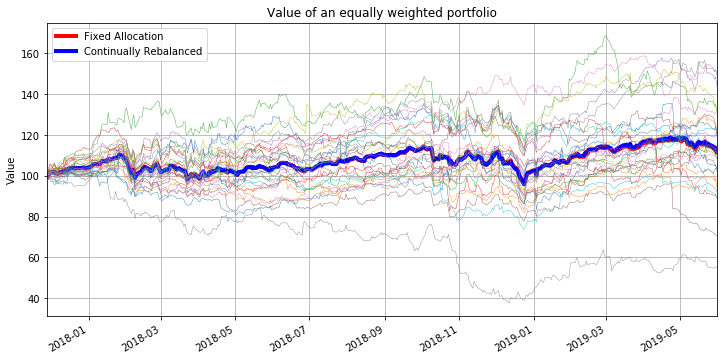

In [45]:
plt.figure(figsize=(12,6))

portfolio = S.columns
J = len(portfolio)

# equal weight with no rebalancing
n = 100.0/S.iloc[0]/J
W_fixed = sum(n[s]*S[s] for s in portfolio)
W_fixed.plot(color='r',lw=4)

# equal weighting with continual rebalancing
R = (S[1:]/S.shift(1)[1:]).sum(axis=1)/len(portfolio)
W_rebal = 100*R.cumprod()
W_rebal.plot(color='b', lw=4)

# individual assets
for s in portfolio:
    (100.0*S[s]/S[s][0]).plot(lw=0.4)
    
plt.legend(['Fixed Allocation','Continually Rebalanced'])
plt.ylabel('Value');
plt.title('Value of an equally weighted portfolio')
plt.grid(True)

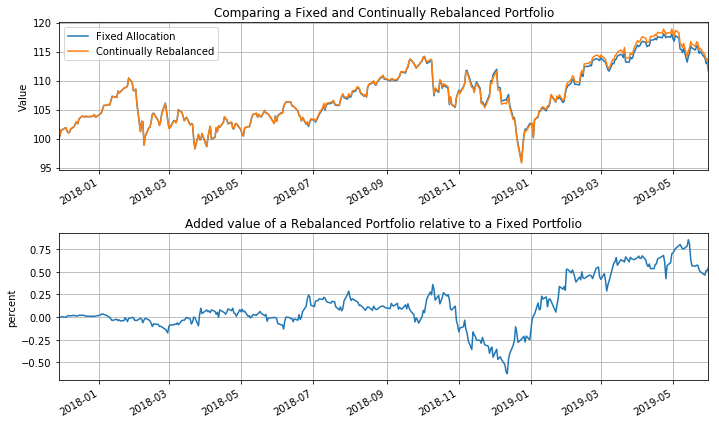

In [49]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
W_fixed.plot()
W_rebal.plot()
plt.legend(['Fixed Allocation','Continually Rebalanced'])
plt.ylabel('Value')
plt.title('Comparing a Fixed and Continually Rebalanced Portfolio')
plt.grid(True)

plt.subplot(2,1,2)
(100.0*(W_rebal-W_fixed)/W_fixed).plot()
plt.title('Added value of a Rebalanced Portfolio relative to a Fixed Portfolio')
plt.ylabel('percent')
plt.grid(True)

plt.tight_layout()

### Component returns

Given data on the prices for a set of assets over an historical period $t_0, t_1, \ldots, t_K$, an estimate the mean arithmetic return is given by the mean value

\begin{align*}
\hat{r}_{j,t_K} & = \frac{1}{K}\sum_{k=1}^{K} r_{t_k} \\
& = \sum_{k=1}^{K} \frac{S_{j,t_{k}}-S_{j,t_{k-1}}}{S_{j,t_{k-1}}}
\end{align*}

At any point in time, $t_k$, a mean return can be computed using the previous $H$ intervals

\begin{align*}
\hat{r}^H_{j,t_k} & = \frac{1}{H}\sum_{h=0}^{H-1} r_{t_{k-h}} \\
& = \frac{1}{H} \sum_{h=0}^{H-1}\frac{S_{j,t_{k-h}} - S_{j,t_{k-h-1}}}{S_{j,t_{k-h-1}}}
\end{align*}

Arithmetic returns are computed so that subsequent calculations combine returns across components of a portfolio.

## Measuring deviation in component returns

### Mean absolute deviation

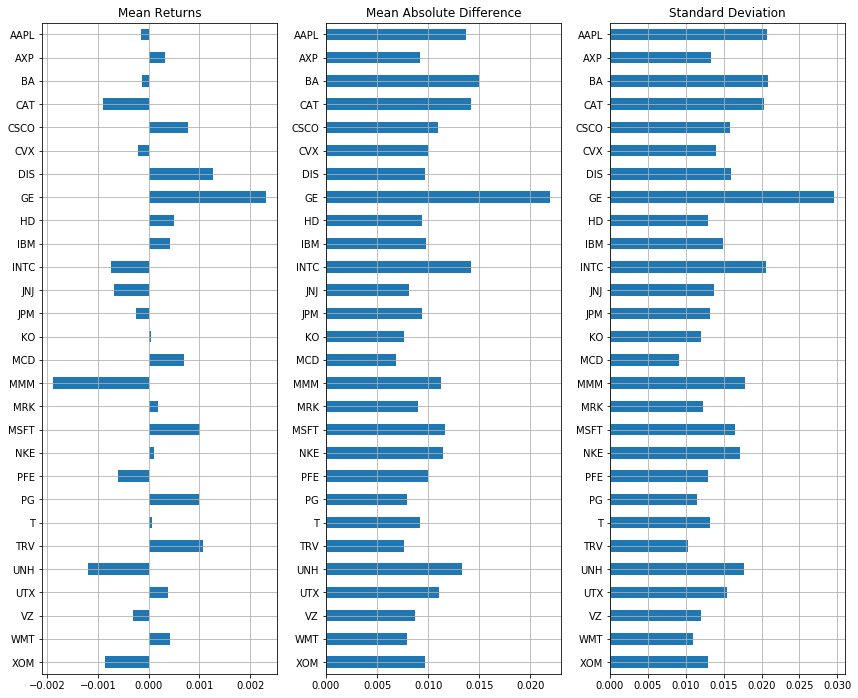

In [30]:
def roll(H):
    """Plot mean returns, mean absolute deviation, and standard deviation for last H days."""
    K = len(S.index)
    R = S[K-H-1:K].diff()[1:]/S[K-H-1:K].shift(1)[1:]
    AD = abs(R - R.mean())
    
    plt.figure(figsize = (12, 0.35*len(R.columns)))
    ax = [plt.subplot(1,3,i+1) for i in range(0,3)]
    
    idx = R.columns.argsort()[::-1]

    R.mean().iloc[idx].plot(ax=ax[0], kind='barh')
    ax[0].set_title('Mean Returns');
    
    AD.mean().iloc[idx].plot(ax=ax[1], kind='barh')
    ax[1].set_title('Mean Absolute Difference')

    R.std().iloc[idx].plot(ax=ax[2], kind='barh')
    ax[2].set_title('Standard Deviation')
    
    for a in ax: a.grid(True)
    plt.tight_layout()

roll(500)

### Comparing mean absolute deviation to standard deviation

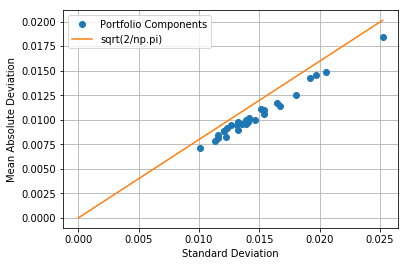

In [51]:
R = (S.diff()[1:]/S.shift(1)[1:]).dropna(axis=0, how='all')
AD = abs(R - R.mean())

plt.plot(R.std(), AD.mean(), 'o')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Absolute Deviation')

plt.plot([0,R.std().max()],[0,np.sqrt(2.0/np.pi)*R.std().max()])
plt.legend(['Portfolio Components','sqrt(2/np.pi)'],loc='best')
plt.grid(True)

### Return versus mean absolute deviation for an equally weighted continually rebalanced portfolio

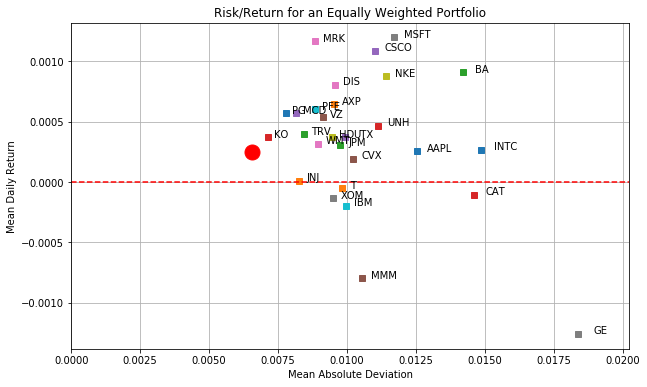

In [52]:
plt.figure(figsize=(10,6))
for s in portfolio:
    plt.plot(AD[s].mean(), R[s].mean(),'s')
    plt.text(AD[s].mean()*1.03, R[s].mean(), s)
    
R_equal = W_rebal.diff()[1:]/W_rebal[1:]
M_equal = abs(R_equal-R_equal.mean()).mean()

plt.plot(M_equal, R_equal.mean(), 'ro', ms=15)

plt.xlim(0, 1.1*max(AD.mean()))
plt.ylim(min(0, 1.1*min(R.mean())), 1.1*max(R.mean()))
plt.plot(plt.xlim(),[0,0],'r--');
plt.title('Risk/Return for an Equally Weighted Portfolio')
plt.xlabel('Mean Absolute Deviation')
plt.ylabel('Mean Daily Return');
plt.grid(True)

## MAD porfolio

The linear program is formulated and solved using Pyomo. 

In [15]:
R.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,HD,IBM,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2017-11-29,-0.020743,0.013855,0.004888,-0.006691,-0.006627,0.006269,0.017697,0.003804,0.008892,0.007083,...,0.013090,0.010041,-0.000223,0.029929,0.011428,0.031184,0.003823,0.022122,0.008164,0.007346
2017-11-30,0.013984,0.011491,0.027850,0.022382,-0.004802,0.015446,-0.003991,-0.010278,0.014500,0.002735,...,0.000995,0.001382,0.006824,-0.002742,0.007731,0.027100,0.027844,0.019841,-0.003383,0.012398
2017-12-01,-0.004655,0.001535,-0.019581,0.002621,0.008042,0.004370,0.004103,-0.022419,0.003337,0.005131,...,-0.005629,0.002482,0.004112,0.003298,0.004720,-0.006092,-0.010951,0.007073,0.001235,0.002042
2017-12-04,-0.007308,0.007460,0.024283,-0.000141,0.003191,0.011129,0.047221,0.003917,0.024831,0.010985,...,0.003674,-0.007978,0.011620,0.021096,0.001101,-0.023635,-0.000666,0.009171,-0.003493,0.001318
2017-12-05,-0.000943,0.001217,-0.008742,-0.009611,-0.010868,-0.003724,-0.027218,-0.010588,-0.011087,-0.007094,...,0.005325,-0.011926,-0.000110,-0.019318,-0.007627,-0.006007,0.002082,-0.015468,0.008453,-0.008137


The decision variables will be indexed by date/time.  The pandas dataframes containing the returns data are indexed by timestamps that include characters that cannot be used by the GLPK solver. Therefore we create a dictionary to translate the pandas timestamps to strings that can be read as members of a GLPK set. The strings denote seconds in the current epoch as defined by python.

In [16]:
a = R - R.mean()
a.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,HD,IBM,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2017-11-29,-0.020998,0.013211,0.003979,-0.006585,-0.007715,0.006077,0.016889,0.005060,0.008521,0.007281,...,0.012214,0.009439,-0.000793,0.029980,0.011030,0.030717,0.003451,0.021583,0.007846,0.007479
2017-11-30,0.013729,0.010847,0.026940,0.022488,-0.005891,0.015254,-0.004798,-0.009022,0.014129,0.002932,...,0.000119,0.000780,0.006255,-0.002692,0.007334,0.026633,0.027473,0.019302,-0.003701,0.012531
2017-12-01,-0.004910,0.000892,-0.020491,0.002727,0.006954,0.004178,0.003295,-0.021163,0.002966,0.005328,...,-0.006505,0.001880,0.003543,0.003348,0.004323,-0.006559,-0.011323,0.006534,0.000917,0.002175
2017-12-04,-0.007563,0.006817,0.023374,-0.000035,0.002103,0.010937,0.046413,0.005173,0.024461,0.011182,...,0.002798,-0.008580,0.011051,0.021147,0.000704,-0.024102,-0.001038,0.008632,-0.003811,0.001451
2017-12-05,-0.001198,0.000574,-0.009651,-0.009505,-0.011957,-0.003916,-0.028025,-0.009331,-0.011457,-0.006897,...,0.004449,-0.012528,-0.000680,-0.019268,-0.008024,-0.006474,0.001711,-0.016007,0.008135,-0.008004


## Minimizing MAD for a portfolio

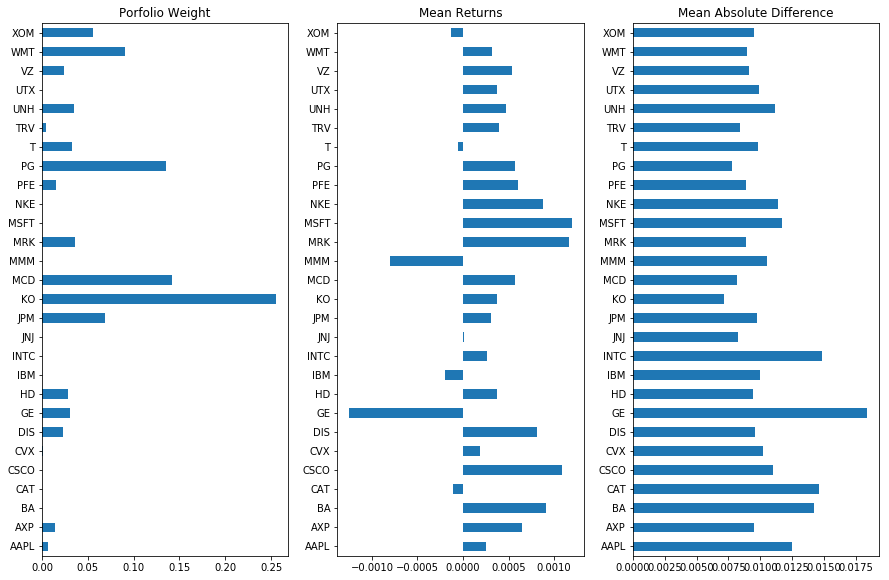

In [17]:
from pyomo.environ import *

a = R - R.mean()

m = ConcreteModel()

m.w = Var(R.columns, domain=NonNegativeReals)
m.y = Var(R.index, domain=NonNegativeReals)

m.MAD = Objective(expr=sum(m.y[t] for t in R.index)/len(R.index), sense=minimize)

m.c1 = Constraint(R.index, rule = lambda m, t: m.y[t] + sum(a.loc[t,s]*m.w[s] for s in R.columns) >= 0)
m.c2 = Constraint(R.index, rule = lambda m, t: m.y[t] - sum(a.loc[t,s]*m.w[s] for s in R.columns) >= 0)
m.c3 = Constraint(expr=sum(R[s].mean()*m.w[s] for s in R.columns) >= R_equal.mean())
m.c4 = Constraint(expr=sum(m.w[s] for s in R.columns)==1)

SolverFactory('glpk').solve(m)

w = {s: m.w[s]() for s in R.columns}

plt.figure(figsize = (15,0.35*len(R.columns)))

plt.subplot(1,3,1)
pd.Series(w).plot(kind='barh')
plt.title('Porfolio Weight');

plt.subplot(1,3,2)
R.mean().plot(kind='barh')
plt.title('Mean Returns');

plt.subplot(1,3,3)
AD.mean().plot(kind='barh')
plt.title('Mean Absolute Difference');

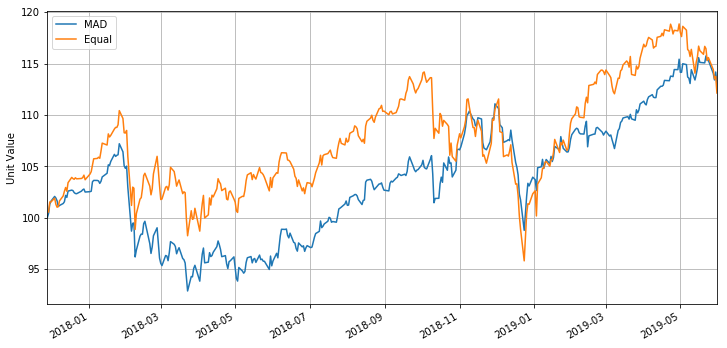

In [54]:
P_mad = pd.Series(0, index=S.index)
for s in portfolio:
    P_mad += 100.0*w[s]*S[s]/S[s][0]
    
plt.figure(figsize=(12,6))
P_mad.plot()
W_rebal.plot()
plt.legend(['MAD','Equal'],loc='best')
plt.ylabel('Unit Value')
plt.grid(True)

Text(0, 0.5, 'Mean Daily Return')

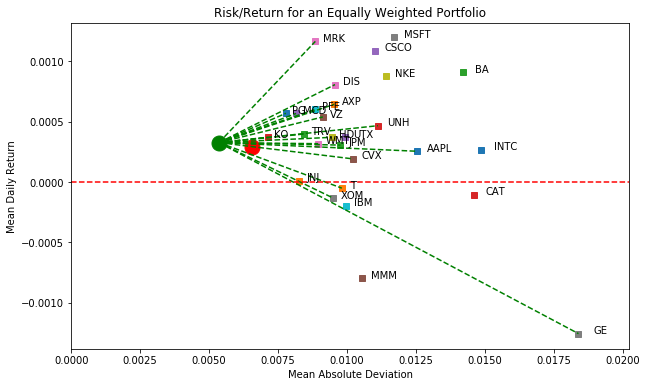

In [19]:
plt.figure(figsize=(10,6))
for s in portfolio:
    plt.plot(AD[s].mean(), R[s].mean(),'s')
    plt.text(AD[s].mean()*1.03, R[s].mean(), s)
    
#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = np.log(W_rebal/W_rebal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plt.plot(M_equal, R_equal.mean(), 'ro', ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = np.log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

plt.plot(M_mad, R_mad.mean(), 'go', ms=15)

for s in portfolio:
    if w[s] >= 0.0001:
        plt.plot([M_mad, AD[s].mean()],[R_mad.mean(), R[s].mean()],'g--')
    if w[s] <= -0.0001:
        plt.plot([M_mad, AD[s].mean()],[R_mad.mean(), R[s].mean()],'r--')

plt.xlim(0, 1.1*max(AD.mean()))
plt.ylim(min(0, 1.1*min(R.mean())), 1.1*max(R.mean()))
plt.plot(plt.xlim(),[0,0],'r--');
plt.title('Risk/Return for an Equally Weighted Portfolio')
plt.xlabel('Mean Absolute Deviation')
plt.ylabel('Mean Daily Return')

In [53]:
import pulp

# mean absolute deviation for the portfolio
m = pulp.LpVariable('m', lowBound = 0)

# dictionary of portfolio weights
w = pulp.LpVariable.dicts('w', portfolio, lowBound = 0)

# dictionary of absolute deviations of portfolio returns
y = pulp.LpVariable.dicts('y', t.values(), lowBound = 0)
z = pulp.LpVariable.dicts('z', t.values(), lowBound = 0)

# create problem instance
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)

# add objective
lp += m

# calculate mean absolute deviation of portfolio returns
lp += m == pulp.lpSum([(y[k] + z[k]) for k in t.values()])/float(len(t))

# relate the absolute deviations to deviations in the portfolio returns
for ts in returns.index:
    lp += y[t[ts]] - z[t[ts]] == pulp.lpSum([w[s]*(returns[s][ts]-returns[s].mean()) for s in portfolio]) 
    
# portfolio weights
lp += pulp.lpSum([w[s] for s in portfolio]) == 1.0

# bound on average portfolio return
lp += pulp.lpSum([w[s]*(returns[s].mean()) for s in portfolio]) >= 0*R_equal.mean()

lp.solve()
print(pulp.LpStatus[lp.status])

ModuleNotFoundError: No module named 'pulp'

In [ ]:
figure(figsize = (15,0.35*len(returns.columns)))

ws = pd.Series({s: w[s].varValue for s in portfolio},index=portfolio)

subplot(1,3,1)
ws.plot(kind='barh')
title('Porfolio Weight');

subplot(1,3,2)
returns.mean().plot(kind='barh')
title('Mean Returns');

subplot(1,3,3)
abs(returns-returns.mean()).mean().plot(kind='barh')
title('Mean Absolute Difference');

In [ ]:
P_mad = pd.Series(0,index=adjclose.index)
for s in portfolio:
    P_mad += 100.0*ws[s]*adjclose[s]/adjclose[s][0]
    
figure(figsize=(12,6))
P_mad.plot()
P_equal.plot()
legend(['MAD','Equal'],loc='best')
ylabel('Unit Value')

In [ ]:
figure(figsize=(10,6))
for s in portfolio:
    plot(mad[s],rmean[s],'s')
    text(mad[s]*1.03,rmean[s],s)
    
axis([0, 1.1*max(mad), min([0,min(rmean)-.1*(max(rmean)-min(rmean))]), 1.1*max(rmean)])
ax = axis()
plot([ax[0],ax[1]],[0,0],'r--');

#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plot(M_equal,R_equal.mean(),'ro',ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

for s in portfolio:
    if ws[s] >= 0.0001:
        plot([M_mad,mad[s]],[R_mad.mean(),rmean[s]],'g--')

plot(M_mad,R_mad.mean(),'go',ms=15)

title('Risk/Return for an Equally Weighted Portfolio')
xlabel('Mean Absolute Deviation')
ylabel('Mean Return')

grid();